# **NUMERICAL METHOD: STANDARD STEP**

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# --- Seeding for reproducibility ---
np.random.seed(42)
torch.manual_seed(42)

# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================================================================
# PART 1: NUMERICAL GROUND TRUTH SOLUTION (STANDARD STEP METHOD)
# ============================================================================
print("\n" + "="*80)
print(" GRADUALLY VARIED FLOW ANALYSIS - TRAPEZOIDAL CHANNEL")
print("="*80)

# --- Channel Parameters ---
CHANNEL_LENGTH = 7000.0      # meters
BED_SLOPE = 0.0002           # dimensionless (S0) - MILD SLOPE
MANNING_N = 0.035            # s/m^(1/3) - Natural channel roughness
GRAVITY = 9.81               # m/s^2
BOTTOM_WIDTH = 50.0          # meters (b)
SIDE_SLOPE = 2.0             # dimensionless (z, H:V ratio)
Q_DESIGN = 424.75            # m^3/s (15,000 cfs)
PROFILE_TYPE = "M2"          # does not affect the pin

print(f"\nChannel Geometry:")
print(f"  Length:           {CHANNEL_LENGTH:,.0f} m")
print(f"  Bottom Width:     {BOTTOM_WIDTH:.1f} m")
print(f"  Side Slope:       {SIDE_SLOPE:.1f}:1 (H:V)")
print(f"  Bed Slope (S0):   {BED_SLOPE:.6f} ({BED_SLOPE*100:.3f}%)")
print(f"  Manning's n:      {MANNING_N:.3f}")
print(f"  Discharge (Q):    {Q_DESIGN:.2f} m³/s ({Q_DESIGN*35.3147:.0f} cfs)")

# ============================================================================
# HYDRAULIC GEOMETRY FUNCTIONS
# ============================================================================

def trap_area(y, b, z):
    """Cross-sectional area of trapezoidal channel
    A = (b + z*y)*y
    """
    return (b + z * y) * y

def trap_wetted_perimeter(y, b, z):
    """Wetted perimeter of trapezoidal channel
    P = b + 2*y*sqrt(1 + z^2)
    """
    return b + 2.0 * y * np.sqrt(1.0 + z**2)

def trap_top_width(y, b, z):
    """Top width of trapezoidal channel
    T = b + 2*z*y
    """
    return b + 2.0 * z * y

def trap_hydraulic_radius(y, b, z):
    """Hydraulic radius R = A/P"""
    A = trap_area(y, b, z)
    P = trap_wetted_perimeter(y, b, z)
    return A / P

def trap_hydraulic_depth(y, b, z):
    """Hydraulic depth D = A/T"""
    A = trap_area(y, b, z)
    T = trap_top_width(y, b, z)
    return A / T

# ============================================================================
# CRITICAL FLOW CALCULATIONS
# ============================================================================

def compute_critical_depth(Q, b, z, tol=1e-8):
    """
    Compute critical depth using Newton-Raphson iteration.

    At critical depth, the specific energy is minimum, which gives:
    Q²/g = A³/T

    Or equivalently: Fr = 1, where Fr = V/sqrt(g*D) and D = A/T
    """
    # Initial guess using rectangular approximation
    yc_init = (Q**2 / (GRAVITY * b**2))**(1/3)

    def critical_equation(y):
        if y <= 0:
            return 1e10
        A = trap_area(y, b, z)
        T = trap_top_width(y, b, z)
        return Q**2 / GRAVITY - A**3 / T

    def critical_derivative(y):
        A = trap_area(y, b, z)
        T = trap_top_width(y, b, z)
        dA_dy = b + 2*z*y  # dA/dy
        dT_dy = 2*z        # dT/dy
        return -(3*A**2*dA_dy*T - A**3*dT_dy) / T**2

    y_c = yc_init
    for iteration in range(100):
        f = critical_equation(y_c)
        df = critical_derivative(y_c)

        if abs(df) < 1e-12:
            break

        y_new = y_c - f / df

        # Ensure positive depth
        if y_new <= 0:
            y_new = y_c / 2.0

        if abs(y_new - y_c) < tol:
            return y_new

        y_c = y_new

    return y_c

def compute_critical_slope(Q, y_n, b, z, n):
    """
    Compute critical slope Sc.

    At critical slope, normal depth = critical depth.
    Sc = (n*Q)^2 / (A*R^(4/3))^2 evaluated at critical depth
    """
    y_c = compute_critical_depth(Q, b, z)
    A_c = trap_area(y_c, b, z)
    R_c = trap_hydraulic_radius(y_c, b, z)

    Sc = (n * Q / (A_c * R_c**(2/3)))**2
    return Sc, y_c

# ============================================================================
# NORMAL DEPTH CALCULATION
# ============================================================================

def compute_normal_depth(Q, b, z, n, S0, tol=1e-8):
    """
    Compute normal depth (uniform flow depth) using Newton-Raphson.

    At normal depth, the friction slope equals the bed slope:
    Sf = S0

    Using Manning's equation:
    Q = (1/n) * A * R^(2/3) * sqrt(S0)

    Rearranged: Q - (1/n) * A * R^(2/3) * sqrt(S0) = 0
    """
    # Initial guess using wide channel approximation: y = (Q*n/(b*sqrt(S0)))^(3/5)
    yn_init = (Q * n / (b * np.sqrt(S0)))**(3/5)

    def normal_depth_equation(y):
        if y <= 0:
            return 1e10
        A = trap_area(y, b, z)
        R = trap_hydraulic_radius(y, b, z)
        Q_computed = (1.0/n) * A * R**(2/3) * np.sqrt(S0)
        return Q - Q_computed

    def normal_depth_derivative(y):
        A = trap_area(y, b, z)
        P = trap_wetted_perimeter(y, b, z)
        R = A / P

        dA_dy = b + 2*z*y
        dP_dy = 2*np.sqrt(1 + z**2)
        dR_dy = (dA_dy * P - A * dP_dy) / P**2

        dQ_dy = (1.0/n) * np.sqrt(S0) * (dA_dy * R**(2/3) + A * (2/3) * R**(-1/3) * dR_dy)
        return -dQ_dy

    y_n = yn_init
    for iteration in range(100):
        f = normal_depth_equation(y_n)
        df = normal_depth_derivative(y_n)

        if abs(df) < 1e-12:
            break

        y_new = y_n - f / df

        if y_new <= 0:
            y_new = y_n / 2.0

        if abs(y_new - y_n) < tol:
            return y_new

        y_n = y_new

    return y_n

# ============================================================================
# COMPUTE CHARACTERISTIC DEPTHS AND CLASSIFY CHANNEL
# ============================================================================

y_normal = compute_normal_depth(Q_DESIGN, BOTTOM_WIDTH, SIDE_SLOPE, MANNING_N, BED_SLOPE)
S_critical, y_critical = compute_critical_slope(Q_DESIGN, y_normal, BOTTOM_WIDTH, SIDE_SLOPE, MANNING_N)

print("\n" + "-"*80)
print(" CHARACTERISTIC DEPTHS AND CHANNEL CLASSIFICATION")
print("-"*80)
print(f"Normal Depth (yn):      {y_normal:.4f} m")
print(f"Critical Depth (yc):    {y_critical:.4f} m")
print(f"Critical Slope (Sc):    {S_critical:.6f} ({S_critical*100:.4f}%)")
print(f"Bed Slope (S0):         {BED_SLOPE:.6f} ({BED_SLOPE*100:.3f}%)")

# Channel classification
if BED_SLOPE < S_critical:
    slope_class = "MILD"
    print(f"\nSlope Classification:   {slope_class} (S0 < Sc)")
    print(f"Normal Flow Regime:     SUBCRITICAL (yn > yc)")
    print(f"Froude Number at yn:    {np.sqrt(Q_DESIGN**2 * trap_top_width(y_normal, BOTTOM_WIDTH, SIDE_SLOPE) / (GRAVITY * trap_area(y_normal, BOTTOM_WIDTH, SIDE_SLOPE)**3)):.4f} < 1")
elif BED_SLOPE > S_critical:
    slope_class = "STEEP"
    print(f"\nSlope Classification:   {slope_class} (S0 > Sc)")
    print(f"Normal Flow Regime:     SUPERCRITICAL (yn < yc)")
else:
    slope_class = "CRITICAL"
    print(f"\nSlope Classification:   {slope_class} (S0 = Sc)")
    print(f"Normal Flow Regime:     CRITICAL (yn = yc)")

print("-"*80)

# ============================================================================
# GRADUALLY VARIED FLOW PROFILE COMPUTATION
# ============================================================================

def compute_friction_slope(Q, y, b, z, n):
    """
    Compute friction slope using Manning's equation:
    Sf = (n*Q / (A*R^(2/3)))^2
    """
    A = trap_area(y, b, z)
    R = trap_hydraulic_radius(y, b, z)
    V = Q / A
    Sf = (n * V / R**(2/3))**2
    return Sf

def compute_velocity_head(Q, y, b, z):
    """Compute velocity head: V^2/(2g)"""
    A = trap_area(y, b, z)
    V = Q / A
    return V**2 / (2.0 * GRAVITY)

def standard_step_method(x_start, x_end, y_start, Q, b, z, n, S0, dx, max_steps=10000):
    """
    Standard Step Method for GVF profile computation.

    Energy equation: E1 + S0*Δx = E2 + Sf_avg*Δx
    where E = y + α*V²/(2g) is specific energy (α ≈ 1.0 for main channel flow)

    For M-type profiles (mild slope), we typically integrate in the direction
    of flow (downstream) or against flow (upstream) depending on control location.

    Args:
        x_start: Starting position (m)
        x_end: Ending position (m)
        y_start: Starting depth (m)
        Q: Discharge (m³/s)
        b, z: Channel geometry
        n: Manning's n
        S0: Bed slope
        dx: Step size (m), positive for downstream, negative for upstream
        max_steps: Maximum number of computational steps
    """
    alpha = 1.0  # Energy coefficient (velocity distribution factor)

    # Determine direction
    if dx > 0:
        direction = "downstream"
    else:
        direction = "upstream"

    # Initialize arrays
    x_profile = [x_start]
    y_profile = [y_start]

    x_current = x_start
    y_current = y_start

    step_count = 0

    while step_count < max_steps:
        # Check if we've reached the end
        if (dx > 0 and x_current >= x_end) or (dx < 0 and x_current <= x_end):
            break

        # Adjust step size if we're close to the end
        if abs(x_end - x_current) < abs(dx):
            dx = x_end - x_current

        # Current energy components
        A_current = trap_area(y_current, b, z)
        V_current = Q / A_current
        E_current = y_current + alpha * V_current**2 / (2.0 * GRAVITY)

        # Iteratively solve for next depth using energy equation
        y_next = y_current  # Initial guess

        for iteration in range(50):
            # Compute properties at next section
            A_next = trap_area(y_next, b, z)
            V_next = Q / A_next
            E_next = y_next + alpha * V_next**2 / (2.0 * GRAVITY)

            # Average friction slope
            Sf_current = compute_friction_slope(Q, y_current, b, z, n)
            Sf_next = compute_friction_slope(Q, y_next, b, z, n)
            Sf_avg = 0.5 * (Sf_current + Sf_next)

            # Energy equation: E1 + S0*dx = E2 + Sf_avg*dx
            # Rearranged: E2 = E1 + (S0 - Sf_avg)*dx
            E_next_computed = E_current + (S0 - Sf_avg) * dx

            # Residual
            residual = E_next - E_next_computed

            if abs(residual) < 1e-6:
                break

            # Newton-Raphson update
            # dE/dy = 1 + d(αV²/2g)/dy = 1 - α*V²*dA/dy / (g*A²)
            dA_dy = b + 2*z*y_next
            dE_dy = 1.0 - alpha * V_next**2 * dA_dy / (GRAVITY * A_next**2)

            if abs(dE_dy) < 1e-10:
                dE_dy = 1e-10  # Avoid division by zero near critical depth

            y_next = y_next - residual / dE_dy

            # Check for critical depth crossing (for drawdown curves like M2)
            # We check if dx is positive (downstream) and y_next is approaching yc
            if dx > 0 and y_next <= (y_critical + 1e-6): # Added 1e-6 as a small buffer
                print(f"  [Solver] Computation stopping near x ≈ {x_current:.1f} m. Reached critical depth (y = {y_next:.4f} m <= yc = {y_critical:.4f} m).")
                step_count = max_steps + 1 # Force outer loop to terminate
                break # Break inner 'for' loop

            # General failsafe for other instabilities (e.g., negative depth)
            elif y_next <= 0:
                print(f"  [Solver] Computation failed at x ≈ {x_current:.1f} m. Depth became non-positive.")
                step_count = max_steps + 1 # Force outer loop to terminate
                break # Break inner 'for' loop

        # Update position and depth
        x_current += dx
        y_current = y_next

        x_profile.append(x_current)
        y_profile.append(y_current)

        step_count += 1

    return np.array(x_profile), np.array(y_profile)

# ============================================================================
# DETERMINE BOUNDARY CONDITIONS AND PROFILE TYPE
# ============================================================================

print("\n" + "-"*80)
print(" BOUNDARY CONDITIONS AND PROFILE DETERMINATION")
print("-"*80)

if PROFILE_TYPE == "M1":
    # --- M1 Profile (Backwater Curve) ---
    # Condition: y > yn
    # Control: Downstream (e.g., a dam), so we integrate UPSTREAM.

    # Impose a depth 0.5m *above* normal depth at the downstream end
    y_downstream_control = y_normal + 0.5

    print(f"\nProfile Type: M1 (Backwater Curve)")
    print(f"  Condition: y > yn")
    print(f"  Control: Downstream @ x = {CHANNEL_LENGTH:.0f} m")
    print(f"  Boundary: y({CHANNEL_LENGTH:.0f}) = {y_downstream_control:.4f} m")

    # Compute M1 profile by integrating UPSTREAM (negative dx)
    dx_step = -50.0
    x_numerical, y_numerical = standard_step_method(
        x_start=CHANNEL_LENGTH,
        x_end=0.0,
        y_start=y_downstream_control,
        Q=Q_DESIGN,
        b=BOTTOM_WIDTH,
        z=SIDE_SLOPE,
        n=MANNING_N,
        S0=BED_SLOPE,
        dx=dx_step
    )

    # Reverse arrays so they go from upstream (x=0) to downstream (x=L)
    x_numerical = x_numerical[::-1]
    y_numerical = y_numerical[::-1]

elif PROFILE_TYPE == "M2":
    # --- M2 Profile (Drawdown Curve) ---
    # Condition: yn > y > yc
    # Control: Upstream (e.g., sluice gate) or downstream (e.g., free overfall).
    # We will model an upstream control, integrating DOWNSTREAM.

    # --- M2 Profile (Drawdown Curve) ---
    # We will set an UPSTREAM control depth between yn (5.95) and yc (1.90)
    y_upstream_control = 5.80

    if not (y_normal > y_upstream_control > y_critical):
        print(f"WARNING: Chosen upstream depth {y_upstream_control:.4f} m is not in the valid M2 range ({y_critical:.4f} < y < {y_normal:.4f})")

    print(f"\nProfile Type: M2 (Drawdown Curve)")
    print(f"  Condition: yn > y > yc")
    print(f"  Control: Upstream @ x = 0 m")
    print(f"  Boundary: y(0) = {y_upstream_control:.4f} m")

    # Compute M2 profile by integrating DOWNSTREAM (positive dx)
    dx_step = 50.0
    x_numerical, y_numerical = standard_step_method(
        x_start=0.0,
        x_end=CHANNEL_LENGTH,
        y_start=y_upstream_control,
        Q=Q_DESIGN,
        b=BOTTOM_WIDTH,
        z=SIDE_SLOPE,
        n=MANNING_N,
        S0=BED_SLOPE,
        dx=dx_step
    )
    # CRITICAL: We do NOT reverse the arrays, as we integrated from 0 to L.
    # The original [::-1] lines are gone.

else:
    raise ValueError(f"Unknown PROFILE_TYPE: '{PROFILE_TYPE}'. Must be 'M1' or 'M2'.")

# Can extract numerical solutions at key locations
x_ground_truth = np.array([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000])
y_ground_truth = np.interp(x_ground_truth, x_numerical, y_numerical)

print("\n" + "-"*80)
print(" GROUND TRUTH WATER SURFACE PROFILE")
print("-"*80)
print(f"{'Distance (m)':>12} | {'Depth (m)':>10} | {'Δ from yn (m)':>14} | {'Sf':>10} | {'Fr':>8}")
print("-"*80)

for i, (x_i, y_i) in enumerate(zip(x_ground_truth, y_ground_truth)):
    Sf_i = compute_friction_slope(Q_DESIGN, y_i, BOTTOM_WIDTH, SIDE_SLOPE, MANNING_N)
    A_i = trap_area(y_i, BOTTOM_WIDTH, SIDE_SLOPE)
    D_i = trap_hydraulic_depth(y_i, BOTTOM_WIDTH, SIDE_SLOPE)
    V_i = Q_DESIGN / A_i
    Fr_i = V_i / np.sqrt(GRAVITY * D_i)

    print(f"{x_i:12.0f} | {y_i:10.4f} | {y_i - y_normal:+14.4f} | {Sf_i:.8f} | {Fr_i:8.4f}")

print("-"*80)

# Verify profile characteristics
if PROFILE_TYPE == "M1":
    print("\nM1 Profile Verification:")
    print(f"  ✓ All depths > normal depth (yn): {np.all(y_ground_truth > y_normal)}")
    print(f"  ✓ All depths > critical depth (yc): {np.all(y_ground_truth > y_critical)}")
    print(f"  ✓ Depth increases downstream: {y_ground_truth[-1] > y_ground_truth[0]}")
    print(f"  ✓ All Froude numbers < 1 (subcritical): {np.all([Q_DESIGN / trap_area(y, BOTTOM_WIDTH, SIDE_SLOPE) / np.sqrt(GRAVITY * trap_hydraulic_depth(y, BOTTOM_WIDTH, SIDE_SLOPE)) < 1 for y in y_ground_truth])}")
elif PROFILE_TYPE == "M2":
    print("\nM2 Profile Verification:")
    print(f"  ✓ All depths < normal depth (yn): {np.all(y_ground_truth < y_normal)}")
    print(f"  ✓ All depths > critical depth (yc): {np.all(y_ground_truth > y_critical)}")
    print(f"  ✓ Depth decreases downstream: {y_ground_truth[-1] < y_ground_truth[0]}")
    print(f"  ✓ All Froude numbers < 1 (subcritical): {np.all([Q_DESIGN / trap_area(y, BOTTOM_WIDTH, SIDE_SLOPE) / np.sqrt(GRAVITY * trap_hydraulic_depth(y, BOTTOM_WIDTH, SIDE_SLOPE)) < 1 for y in y_ground_truth])}")

Using device: cuda

 GRADUALLY VARIED FLOW ANALYSIS - TRAPEZOIDAL CHANNEL

Channel Geometry:
  Length:           7,000 m
  Bottom Width:     50.0 m
  Side Slope:       2.0:1 (H:V)
  Bed Slope (S0):   0.000200 (0.020%)
  Manning's n:      0.035
  Discharge (Q):    424.75 m³/s (15000 cfs)

--------------------------------------------------------------------------------
 CHARACTERISTIC DEPTHS AND CHANNEL CLASSIFICATION
--------------------------------------------------------------------------------
Normal Depth (yn):      5.9567 m
Critical Depth (yc):    1.8949 m
Critical Slope (Sc):    0.010141 (1.0141%)
Bed Slope (S0):         0.000200 (0.020%)

Slope Classification:   MILD (S0 < Sc)
Normal Flow Regime:     SUBCRITICAL (yn > yc)
Froude Number at yn:    0.1645 < 1
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
 BOUNDARY CONDITIONS AND PROFILE DETERMINATION
-----------------

# **PINN IMPLEMENTATION**

In [17]:
# ============================================================================
# PART 2: PHYSICS-INFORMED NEURAL NETWORK (PINN)
# ============================================================================

print("\n" + "="*80)
print(" PHYSICS-INFORMED NEURAL NETWORK TRAINING")
print("="*80)

# --- PINN Configuration ---
NUM_COLLOCATION_POINTS = 3000
NUM_BOUNDARY_POINTS = 100
NUM_HIDDEN_LAYERS = 10
NEURONS_PER_LAYER = 64
LEARNING_RATE = 5e-4
NUM_EPOCHS = 24000

# Loss weights - carefully tuned based on physical scales
LAMBDA_PDE = 1.0           # PDE residual
LAMBDA_BC_UP = 20.0       # Upstream BC
LAMBDA_BC_DOWN = 20.0     # Downstream BC

print(f"\nNetwork Configuration:")
print(f"  Architecture: {NUM_HIDDEN_LAYERS} hidden layers × {NEURONS_PER_LAYER} neurons")
print(f"  Activation: Tanh + Softplus output")
print(f"  Collocation points: {NUM_COLLOCATION_POINTS}")
print(f"  Boundary points: {NUM_BOUNDARY_POINTS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Training epochs: {NUM_EPOCHS:,}")

# ============================================================================
# NEURAL NETWORK ARCHITECTURE
# ============================================================================

class PINN_GVF(nn.Module):
    """
    Physics-Informed Neural Network for Gradually Varied Flow.

    Architecture:
    - Input: x (channel position)
    - Output: y (water depth)

    The network is designed to:
    1. Satisfy the steady GVF equation (energy balance)
    2. Match boundary conditions at upstream and downstream
    """

    def __init__(self, num_layers, neurons_per_layer):
        super(PINN_GVF, self).__init__()

        # Input normalization parameters
        self.x_mean = CHANNEL_LENGTH / 2.0
        self.x_std = CHANNEL_LENGTH / 2.0

        layers = []

        # Input layer
        layers.append(nn.Linear(1, neurons_per_layer))
        layers.append(nn.Tanh())

        # Hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(nn.Tanh())

        # Output layer (no activation - we'll apply custom transformation)
        layers.append(nn.Linear(neurons_per_layer, 1))

        self.network = nn.Sequential(*layers)

        # We will also add the softplus function as a module
        self.softplus = nn.Softplus()

        # Initialize weights using Xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        """
        Forward pass with output transformation to ensure physical bounds.

        Maps network output to positive domain, avoiding negative depth predictions.
        """
        # Normalize input
        x_norm = (x - self.x_mean) / self.x_std

        # Network prediction
        y_raw = self.network(x_norm)

        # Softplus transform
        # This ensures y > 0 always, with no upper bound.
        # We add a small offset (0.01) to prevent y=0,
        # which can be numerically unstable for Sf calculation.
        y = 0.01 + self.softplus(y_raw)

        return y

# Initialize network
pinn_model = PINN_GVF(NUM_HIDDEN_LAYERS, NEURONS_PER_LAYER).to(device)

total_params = sum(p.numel() for p in pinn_model.parameters())
print(f"  Total parameters: {total_params:,}")

# ============================================================================
# TENSOR-COMPATIBLE HYDRAULIC FUNCTIONS
# ============================================================================

def calc_area_torch(y, b, z):
    """Area of trapezoidal channel (PyTorch version)"""
    b_t = torch.tensor(b, device=y.device, dtype=y.dtype)
    z_t = torch.tensor(z, device=y.device, dtype=y.dtype)
    return (b_t + z_t * y) * y

def calc_perimeter_torch(y, b, z):
    """Wetted perimeter (PyTorch version)"""
    b_t = torch.tensor(b, device=y.device, dtype=y.dtype)
    z_t = torch.tensor(z, device=y.device, dtype=y.dtype)
    return b_t + 2.0 * y * torch.sqrt(1.0 + z_t**2)

def calc_hydraulic_radius_torch(y, b, z):
    """Hydraulic radius (PyTorch version)"""
    A = calc_area_torch(y, b, z)
    P = calc_perimeter_torch(y, b, z)
    return A / (P + 1e-8)

def calc_top_width_torch(y, b, z):
    """Top width (PyTorch version)"""
    b_t = torch.tensor(b, device=y.device, dtype=y.dtype)
    z_t = torch.tensor(z, device=y.device, dtype=y.dtype)
    return b_t + 2.0 * z_t * y

# ============================================================================
# LOSS FUNCTION
# ============================================================================

def loss_function_gvf(model, x_coll, x_up, x_down, y_up_target, y_down_target, Q, b, z, n, S0, g):
    """
    Complete loss function for GVF PINN.

    Components:
    1. PDE residual: Energy equation dE/dx = S0 - Sf
    2. Upstream BC: y(0) = y_upstream
    3. Downstream BC: y(L) = y_downstream
    """

    # Convert constants to tensors
    Q_t = torch.tensor(Q, device=x_coll.device, dtype=x_coll.dtype)
    n_t = torch.tensor(n, device=x_coll.device, dtype=x_coll.dtype)
    S0_t = torch.tensor(S0, device=x_coll.device, dtype=x_coll.dtype)
    g_t = torch.tensor(g, device=x_coll.device, dtype=x_coll.dtype)

    # ========================================================================
    # 1. PDE RESIDUAL (Energy Equation)
    # ========================================================================
    x_coll.requires_grad_(True)
    y_coll = model(x_coll)

    # Compute hydraulic properties
    A_coll = calc_area_torch(y_coll, b, z)
    R_coll = calc_hydraulic_radius_torch(y_coll, b, z)
    V_coll = Q_t / A_coll

    # Friction slope using Manning's equation
    Sf_coll = (n_t * V_coll / (R_coll**(2.0/3.0) + 1e-8))**2

    # Specific energy E = y + V²/(2g)
    E_coll = y_coll + V_coll**2 / (2.0 * g_t)

    # Compute dE/dx using automatic differentiation
    dE_dx = torch.autograd.grad(
        outputs=E_coll,
        inputs=x_coll,
        grad_outputs=torch.ones_like(E_coll),
        create_graph=True,
        retain_graph=True
    )[0]

    # GVF equation: dE/dx = S0 - Sf
    pde_residual = dE_dx - (S0_t - Sf_coll)
    loss_pde = torch.mean(pde_residual**2)

    # ========================================================================
    # 2. BOUNDARY CONDITIONS
    # ========================================================================

    # Upstream BC: y(0) = y_upstream
    y_up_pred = model(x_up)
    y_up_target_t = torch.tensor(y_up_target, device=y_up_pred.device, dtype=y_up_pred.dtype)
    loss_bc_up = torch.mean((y_up_pred - y_up_target_t)**2)

    # Downstream BC: y(L) = y_downstream
    y_down_pred = model(x_down)
    y_down_target_t = torch.tensor(y_down_target, device=y_down_pred.device, dtype=y_down_pred.dtype)
    loss_bc_down = torch.mean((y_down_pred - y_down_target_t)**2)

    # ========================================================================
    # 3. TOTAL LOSS
    # ========================================================================

    total_loss = (LAMBDA_PDE * loss_pde +
              LAMBDA_BC_UP * loss_bc_up +
              LAMBDA_BC_DOWN * loss_bc_down)

    return total_loss, loss_pde, loss_bc_up, loss_bc_down

# ============================================================================
# TRAINING SETUP
# ============================================================================

# Generate training points
x_collocation = torch.rand(NUM_COLLOCATION_POINTS, 1, device=device) * CHANNEL_LENGTH
x_upstream = torch.zeros(NUM_BOUNDARY_POINTS, 1, device=device)
x_downstream = torch.full((NUM_BOUNDARY_POINTS, 1), CHANNEL_LENGTH, device=device)

# Boundary values
Y_UPSTREAM = float(y_ground_truth[0])
Y_DOWNSTREAM = float(y_ground_truth[-1])

print(f"\nBoundary Conditions:")
print(f"  Upstream (x=0):           y = {Y_UPSTREAM:.4f} m")
print(f"  Downstream (x={CHANNEL_LENGTH:.0f}):      y = {Y_DOWNSTREAM:.4f} m")

# Optimizer with adaptive learning rate
optimizer = torch.optim.Adam(pinn_model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2000,
    min_lr=1e-7
)

# Loss history storage
loss_history = {
    'total': [],
    'pde': [],
    'bc_up': [],
    'bc_down': []
}

# ============================================================================
# TRAINING LOOP
# ============================================================================

print("\n" + "-"*80)
print(" TRAINING PROGRESS")
print("-"*80)
print(f"{'Epoch':>8} | {'Total Loss':>12} | {'PDE':>10} | {'BC_up':>10} | {'BC_down':>10}")
print("-"*80)

best_loss = float('inf')
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    pinn_model.train()
    optimizer.zero_grad()

    # Compute loss
    total_loss, pde_loss, bc_up_loss, bc_down_loss = loss_function_gvf(
        model=pinn_model,
        x_coll=x_collocation,
        x_up=x_upstream,
        x_down=x_downstream,
        y_up_target=Y_UPSTREAM,
        y_down_target=Y_DOWNSTREAM,
        Q=Q_DESIGN,
        b=BOTTOM_WIDTH,
        z=SIDE_SLOPE,
        n=MANNING_N,
        S0=BED_SLOPE,
        g=GRAVITY
    )

    # Backward pass and optimization
    total_loss.backward()

    # Gradient clipping to prevent instability
    torch.nn.utils.clip_grad_norm_(pinn_model.parameters(), max_norm=1.0)

    optimizer.step()
    scheduler.step(total_loss)

    # Store loss history
    loss_history['total'].append(total_loss.item())
    loss_history['pde'].append(pde_loss.item())
    loss_history['bc_up'].append(bc_up_loss.item())
    loss_history['bc_down'].append(bc_down_loss.item())

    # Track best model
    if total_loss.item() < best_loss:
        best_loss = total_loss.item()
        patience_counter = 0
    else:
        patience_counter += 1

    # Print progress
    if (epoch + 1) % 2000 == 0 or epoch == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"{epoch+1:8d} | {total_loss.item():12.6e} | {pde_loss.item():10.4e} | "
              f"{bc_up_loss.item():10.4e} | {bc_down_loss.item():10.4e} | ")

print("-"*80)
print(f"Training completed! Best loss: {best_loss:.6e}")

# ============================================================================
# PART 3: EVALUATION AND VALIDATION
# ============================================================================

print("\n" + "="*80)
print(" MODEL EVALUATION AND VALIDATION")
print("="*80)

pinn_model.eval()

# Generate fine-resolution predictions
x_test = torch.linspace(0, CHANNEL_LENGTH, 1001, device=device).view(-1, 1)

with torch.no_grad():
    y_pred = pinn_model(x_test).cpu().numpy()

x_test_np = x_test.cpu().numpy().flatten()

# Interpolate PINN predictions at ground truth locations
y_pred_at_gt = np.interp(x_ground_truth, x_test_np, y_pred.flatten())

# ============================================================================
# COMPUTE ERROR METRICS
# ============================================================================

errors = y_pred_at_gt - y_ground_truth
abs_errors = np.abs(errors)
rel_errors = 100.0 * abs_errors / y_ground_truth

mae = np.mean(abs_errors)
rmse = np.sqrt(np.mean(errors**2))
max_abs_error = np.max(abs_errors)
mean_rel_error = np.mean(rel_errors)

print(f"\nError Metrics:")
print(f"  Mean Absolute Error (MAE):     {mae:.6f} m ({mae*1000:.3f} mm)")
print(f"  Root Mean Square Error (RMSE): {rmse:.6f} m ({rmse*1000:.3f} mm)")
print(f"  Maximum Absolute Error:        {max_abs_error:.6f} m ({max_abs_error*1000:.3f} mm)")
print(f"  Mean Relative Error:           {mean_rel_error:.4f}%")

print("\n" + "-"*80)
print(" DETAILED COMPARISON AT KEY LOCATIONS")
print("-"*80)
print(f"{'x (m)':>8} | {'Ground Truth':>13} | {'PINN':>13} | {'Error (mm)':>12} | {'Rel. Error':>11}")
print("-"*80)

for i, x_i in enumerate(x_ground_truth):
    gt = y_ground_truth[i]
    pred = y_pred_at_gt[i]
    err = (pred - gt) * 1000  # Convert to mm
    rel_err = 100.0 * abs(pred - gt) / gt
    print(f"{x_i:8.0f} | {gt:13.6f} m | {pred:13.6f} m | {err:+12.3f} | {rel_err:10.4f}%")

print("-"*80)

# ============================================================================
# VERIFY PHYSICAL CONSTRAINTS
# ============================================================================

print("\n" + "-"*80)
print(" PHYSICAL CONSTRAINT VERIFICATION")
print("-"*80)

with torch.no_grad():
    # Compute hydraulic properties along the profile
    y_test = pinn_model(x_test)

    A_test = calc_area_torch(y_test, BOTTOM_WIDTH, SIDE_SLOPE)
    R_test = calc_hydraulic_radius_torch(y_test, BOTTOM_WIDTH, SIDE_SLOPE)
    T_test = calc_top_width_torch(y_test, BOTTOM_WIDTH, SIDE_SLOPE)
    D_test = A_test / T_test  # Hydraulic depth
    V_test = Q_DESIGN / A_test
    Fr_test = V_test / torch.sqrt(GRAVITY * D_test)

    # Compute friction slope
    Sf_test = (MANNING_N * V_test / R_test**(2.0/3.0))**2

y_test_np = y_test.cpu().numpy().flatten()
V_test_np = V_test.cpu().numpy().flatten()
Fr_test_np = Fr_test.cpu().numpy().flatten()
Sf_test_np = Sf_test.cpu().numpy().flatten()

# Check constraints
all_subcritical = np.all(Fr_test_np < 1.0)
all_above_yn = np.all(y_test_np > y_normal)
all_above_yc = np.all(y_test_np > y_critical)

"""
print(f"✓ All depths > critical depth (yc):  {all_above_yc} (required for M1)")
print(f"✓ All depths > normal depth (yn):    {all_above_yn} (required for M1)")
print(f"✓ All Froude numbers < 1:            {all_subcritical} (subcritical)")
print(f"\nDepth range: [{y_test_np.min():.4f}, {y_test_np.max():.4f}] m")
print(f"Velocity range: [{V_test_np.min():.4f}, {V_test_np.max():.4f}] m/s")
print(f"Froude number range: [{Fr_test_np.min():.4f}, {Fr_test_np.max():.4f}]")
"""


 PHYSICS-INFORMED NEURAL NETWORK TRAINING

Network Configuration:
  Architecture: 10 hidden layers × 64 neurons
  Activation: Tanh + Softplus output
  Collocation points: 3000
  Boundary points: 100
  Learning rate: 0.0005
  Training epochs: 24,000
  Total parameters: 37,633

Boundary Conditions:
  Upstream (x=0):           y = 5.8000 m
  Downstream (x=7000):      y = 5.5549 m

--------------------------------------------------------------------------------
 TRAINING PROGRESS
--------------------------------------------------------------------------------
   Epoch |   Total Loss |        PDE |      BC_up |    BC_down
--------------------------------------------------------------------------------
       1 | 9.900356e+02 | 8.0882e-02 | 2.5695e+01 | 2.3803e+01 | 
    2000 | 1.150668e-03 | 8.5298e-11 | 3.5732e-05 | 2.1801e-05 | 
    4000 | 2.233609e-04 | 2.8219e-10 | 5.1258e-06 | 6.0422e-06 | 
    6000 | 3.682173e-10 | 3.5912e-10 | 2.2737e-13 | 2.2737e-13 | 
    8000 | 4.027608e-10 | 3.6

'\nprint(f"✓ All depths > critical depth (yc):  {all_above_yc} (required for M1)")\nprint(f"✓ All depths > normal depth (yn):    {all_above_yn} (required for M1)")\nprint(f"✓ All Froude numbers < 1:            {all_subcritical} (subcritical)")\nprint(f"\nDepth range: [{y_test_np.min():.4f}, {y_test_np.max():.4f}] m")\nprint(f"Velocity range: [{V_test_np.min():.4f}, {V_test_np.max():.4f}] m/s")\nprint(f"Froude number range: [{Fr_test_np.min():.4f}, {Fr_test_np.max():.4f}]")\n'

# **RESULT VISUALIZATION**


 GENERATING VISUALIZATION


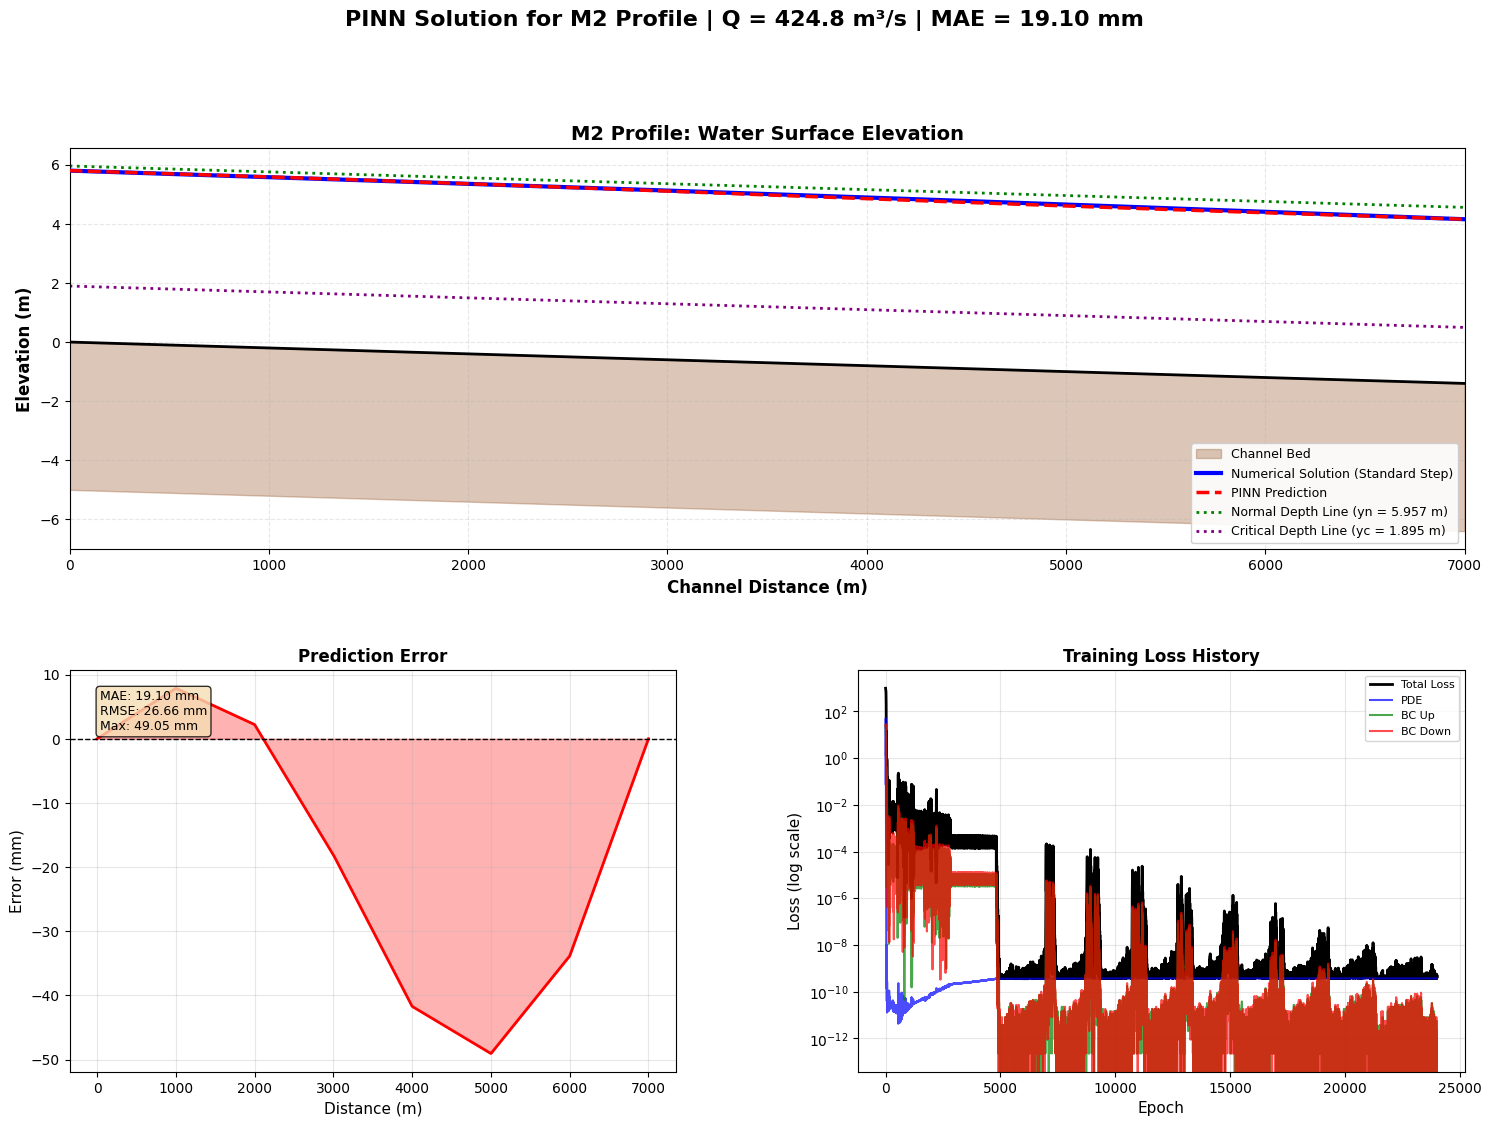


 FINAL SUMMARY

Numerical Solution (Ground Truth):
  Method: Standard Step Method
  Spatial resolution: 141 points
  Depth range: 5.5549 - 5.8000 m

PINN Performance:
  Mean Absolute Error: 19.098 mm (0.3368%)
  Maximum Error: 49.055 mm
  Training epochs: 24,000
  Final loss: 4.632545e-10


In [18]:
# ============================================================================
# PART 4: COMPREHENSIVE VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print(" GENERATING VISUALIZATION")
print("="*80)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2,2, hspace=0.3, wspace=0.3)

# ============================================================================
# Plot 1: Water Surface Profile (Main Result)
# ============================================================================
ax1 = fig.add_subplot(gs[0, :2])

# Plot channel bed
x_bed = np.array([0, CHANNEL_LENGTH])
z_bed = np.array([0, -BED_SLOPE * CHANNEL_LENGTH])

ax1.fill_between(x_bed, z_bed, z_bed - 5, color='saddlebrown', alpha=0.3, label='Channel Bed')
ax1.plot(x_bed, z_bed, 'k-', linewidth=2)

# Plot water surface profiles (relative to datum)
ax1.plot(x_numerical, z_bed[0] - BED_SLOPE * x_numerical + y_numerical,
         'b-', linewidth=3, label='Numerical Solution (Standard Step)', zorder=3)
ax1.plot(x_test_np, z_bed[0] - BED_SLOPE * x_test_np + y_pred.flatten(),
         'r--', linewidth=2.5, label='PINN Prediction', zorder=4)
#ax1.scatter(x_ground_truth, z_bed[0] - BED_SLOPE * x_ground_truth + y_ground_truth,
#            color='green', s=100, marker='o', edgecolors='black', linewidths=1.5,
#            label='Ground Truth Points', zorder=5)

# Reference lines
y_normal_line = z_bed[0] - BED_SLOPE * x_bed + y_normal
y_critical_line = z_bed[0] - BED_SLOPE * x_bed + y_critical

ax1.plot(x_bed, y_normal_line, 'g:', linewidth=2, label=f'Normal Depth Line (yn = {y_normal:.3f} m)')
ax1.plot(x_bed, y_critical_line, 'purple', linestyle=':', linewidth=2,
         label=f'Critical Depth Line (yc = {y_critical:.3f} m)')

ax1.set_xlabel('Channel Distance (m)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Elevation (m)', fontsize=12, fontweight='bold')
ax1.set_title(f'{PROFILE_TYPE} Profile: Water Surface Elevation', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='lower right', fontsize=9, framealpha=0.9)
ax1.set_xlim([0, CHANNEL_LENGTH])

# ============================================================================
# Plot 2: Absolute Error
# ============================================================================
ax2 = fig.add_subplot(gs[1, 0])

error_interp = np.interp(x_test_np, x_ground_truth, errors)
ax2.plot(x_test_np, error_interp * 1000, 'r-', linewidth=2)
ax2.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax2.fill_between(x_test_np, 0, error_interp * 1000, alpha=0.3, color='red')

ax2.set_xlabel('Distance (m)', fontsize=11)
ax2.set_ylabel('Error (mm)', fontsize=11)
ax2.set_title('Prediction Error', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.text(0.05, 0.95, f'MAE: {mae*1000:.2f} mm\nRMSE: {rmse*1000:.2f} mm\nMax: {max_abs_error*1000:.2f} mm',
         transform=ax2.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ============================================================================
# Plot 3: Training Loss History
# ============================================================================
ax3 = fig.add_subplot(gs[1, 1])

epochs_plot = np.arange(1, len(loss_history['total']) + 1)
ax3.semilogy(epochs_plot, loss_history['total'], 'k-', linewidth=2, label='Total Loss')
ax3.semilogy(epochs_plot, loss_history['pde'], 'b-', linewidth=1.5, alpha=0.7, label='PDE')
ax3.semilogy(epochs_plot, loss_history['bc_up'], 'g-', linewidth=1.5, alpha=0.7, label='BC Up')
ax3.semilogy(epochs_plot, loss_history['bc_down'], 'r-', linewidth=1.5, alpha=0.7, label='BC Down')

ax3.set_xlabel('Epoch', fontsize=11)
ax3.set_ylabel('Loss (log scale)', fontsize=11)
ax3.set_title('Training Loss History', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, which='both')
ax3.legend(fontsize=8, loc='upper right')

plt.suptitle(f'PINN Solution for {PROFILE_TYPE} Profile | Q = {Q_DESIGN:.1f} m³/s | MAE = {mae*1000:.2f} mm',
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print(" FINAL SUMMARY")
print("="*80)

print(f"\nNumerical Solution (Ground Truth):")
print(f"  Method: Standard Step Method")
print(f"  Spatial resolution: {len(x_numerical)} points")
print(f"  Depth range: {y_numerical.min():.4f} - {y_numerical.max():.4f} m")

print(f"\nPINN Performance:")
print(f"  Mean Absolute Error: {mae*1000:.3f} mm ({mean_rel_error:.4f}%)")
print(f"  Maximum Error: {max_abs_error*1000:.3f} mm")
print(f"  Training epochs: {NUM_EPOCHS:,}")
print(f"  Final loss: {loss_history['total'][-1]:.6e}")